# IMPORTS & DATA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fbprophet import Prophet
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score


import os
os.getcwd()

'/home/jupyter/tiger/mateo'

In [2]:
path = os.path.realpath('../data/walmart')
train = pd.read_csv(os.path.join(path,'train.csv'), dtype={'Store': np.int8, 'Dept': np.int8})
train['Date'] = pd.to_datetime(train.Date)
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [3]:
Prophet?

Init signature:
Prophet(
    growth='linear',
    changepoints=None,
    n_changepoints=25,
    changepoint_range=0.8,
    yearly_seasonality='auto',
    weekly_seasonality='auto',
    daily_seasonality='auto',
    holidays=None,
    seasonality_mode='additive',
    seasonality_prior_scale=10.0,
    holidays_prior_scale=10.0,
    changepoint_prior_scale=0.05,
    mcmc_samples=0,
    interval_width=0.8,
    uncertainty_samples=1000,
)
Docstring:     
Prophet forecaster.

Parameters
----------
growth: String 'linear' or 'logistic' to specify a linear or logistic
    trend.
changepoints: List of dates at which to include potential changepoints. If
    not specified, potential changepoints are selected automatically.
n_changepoints: Number of potential changepoints to include. Not used
    if input `changepoints` is supplied. If `changepoints` is not supplied,
    then n_changepoints potential changepoints are selected uniformly from
    the first `changepoint_range` proportion of the hist

# Para hacer pruebitas

In [29]:
X_test.shape

(29, 5)

In [26]:
store_1_dpt_n = train[np.logical_and(train.Store==1, train.Dept==6)]
# Los divide en train-test
X_train, X_test, y_train, y_test = train_test_split(store_1_dpt_n.drop(columns=['Weekly_Sales']),
                                                                   store_1_dpt_n.Weekly_Sales, 
                                                                   test_size=0.2, 
                                                                   shuffle=False)
# Cata las features
features = pd.read_csv(os.path.join(path,'features.csv'), parse_dates=True)
# Te cata las features pero solo de la tienda uno
# TODO: que cate las features correspondientes en función de la tienda seleccionada
features['Date'] = pd.to_datetime(features.Date)
features = features[:114+29]
features_train = features[:114]
features_test = features[114:]
# C mete con un valor esperado en Prophet los valores de salida
X_train['y'] = y_train.values
X_test['y'] = y_test.values
# Te une las features con el x_train
X_train2 = pd.merge(X_train, features_train).drop(columns=['Store','Dept','MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4','MarkDown5'])
# Te pone 0 donde hay Nan
# TODO: interpolar los valores
X_train2.fillna(0, inplace=True)
# Te normaliza las features independientemente mediante función gausiana
scaled_features_train = X_train2.copy()
col_names = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
features_ = scaled_features_train[col_names]
scaler = StandardScaler().fit(features_.values)
features_ = scaler.transform(features_.values)
scaled_features_train[col_names] = features_
# Lo mismo de antes pa test
X_test2 = pd.merge(X_test, features_test).drop(columns=['Store','Dept','MarkDown1', 'MarkDown2','MarkDown3', 'MarkDown4','MarkDown5'])
X_test2.fillna(0, inplace=True)
scaled_features_test = X_test2.copy()
col_names = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
features_ = scaled_features_test[col_names]
scaler = StandardScaler().fit(features_.values)
features_ = scaler.transform(features_.values)
scaled_features_test[col_names] = features_
# C renombra para que cuadre con lo esperado por Prophet
scaled_features_train = scaled_features_train.rename(columns={"Date": "ds"})
scaled_features_test = scaled_features_test.rename(columns={"Date": "ds"})
# C mete con un valor esperado en Prophet los valores de salida
####scaled_features_train['y'] = y_train.values
####scaled_features_test['y'] = y_test.values
# Los festivos los trata diferentes y hay que crear un dataframe exclusivo. C haC aquí.
holidays = pd.DataFrame()
holidays['ds'] = scaled_features_train['ds']
holidays['holiday'] = scaled_features_train['IsHoliday']
#scaled_features_train = scaled_features_train.drop(columns='IsHoliday')
# Nos quedamos con los días que son festivos, quitamos los que non.
holidays = holidays[(holidays != False).all(1)]
# Le metemos una serie de variables adicionales que Prophet necesita.
holidays['lower_window'] = np.zeros(len(holidays.values))
holidays['upper_window'] = np.ones(len(holidays.values))
holidays['holiday'] = "festivos en USA"
# Instanciamos prophet con todos los parámetros que nos salga del Qlo
#m = Prophet(mcmc_samples=300, holidays=holidays, holidays_prior_scale=0.25, changepoint_prior_scale=0.01, seasonality_mode='multiplicative', \
#        weekly_seasonality=True, \
#        daily_seasonality=False)
m = Prophet(weekly_seasonality=True, holidays=holidays, holidays_prior_scale=0.1, changepoint_prior_scale=0.05, interval_width = 0.95)
# Le metemos a la instancia cada uno de los features, con el nombre que tenga la columna en el dataframe correspondiente
m.add_regressor('Temperature', prior_scale=0.1, mode='multiplicative')
m.add_regressor('Fuel_Price', prior_scale=0.1, mode='multiplicative')
m.add_regressor('CPI', prior_scale=0.1, mode='multiplicative')
m.add_regressor('Unemployment', prior_scale=0.1, mode='multiplicative')
# Y fiteamos a fuego
m.fit(scaled_features_train)
# Le metemos pa que haga predicción un dataframe con los datos presentes y los de test (en teoría futuros)
all_data_features = pd.concat([scaled_features_train,scaled_features_test]).reset_index(drop=True)
####all_data_features.drop(columns=['ds','IsHoliday','y'])
####all_data_features.drop(columns=['ds','y'])

# Y nos hace una predicción luxury
future_train = m.make_future_dataframe(periods=len(scaled_features_test), freq="W")

# Le damos explicitamente las features futuras (no las predice, logicamente)
future_train = pd.concat([future_train, all_data_features[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']]], axis=1)
# Y ya te hace la predicción completa con las features
forecast = m.predict(future_train)

# Que te pinte las componentes pa ver si ha hecho algo decente o ha sido chiripa
#f = m.plot_components(forecast)
# Pillamos las predicciones del dataframe que se genera (que tiene mazo de mierda) 
y_pred = forecast.yhat[-X_test.shape[0]:]
X_pred = forecast.yhat[:-X_test.shape[0]]
# Y ya que pinte lo que pasa en el futuro, con respecto del pasado, o lo que C a
#plt.figure()
#plt.grid()
#plt.plot(scaled_features_train.ds, y_train)
#plt.plot(scaled_features_test.ds, y_test,'k')
#plt.plot(scaled_features_test.ds, y_pred, 'g')
###########################################################################################

# Esto es de Mario pero C entiende fácil
def percentage_error(y_pred, y_true):
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    return np.mean(np.abs(y_pred-y_true)/y_true)*100

print('Error porcentual prophet: %0.02f' % percentage_error(y_pred.values, y_test.values) + '%')


Error porcentual prophet: -70.88%


In [376]:
y_pred_lower = forecast.yhat_lower[-X_test.shape[0]:]
y_pred_upper = forecast.yhat_upper[-X_test.shape[0]:]

In [377]:
pred_optimista = y_pred.values > y_test.values
pred_pesimista = np.logical_not(pred_optimista)
mean_optimista = int(np.mean(np.abs(y_pred[pred_optimista].values-y_test[pred_optimista].values)/y_test[pred_optimista].values)*100)
mean_pesimista = int(np.mean(np.abs(y_pred[pred_pesimista].values-y_test[pred_pesimista].values)/y_test[pred_pesimista].values)*100)

In [358]:
def isBetweenUncertainty(y_test, y_pred_lower, y_pred_upper):
    inside = 0
    for i in range(len(y_test)):
        if (y_test.values[i] < y_pred_upper.values[i]) and (y_test.values[i] > y_pred_lower.values[i]):
            inside += 1
    return (inside/len(y_test)*100)

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning:


Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



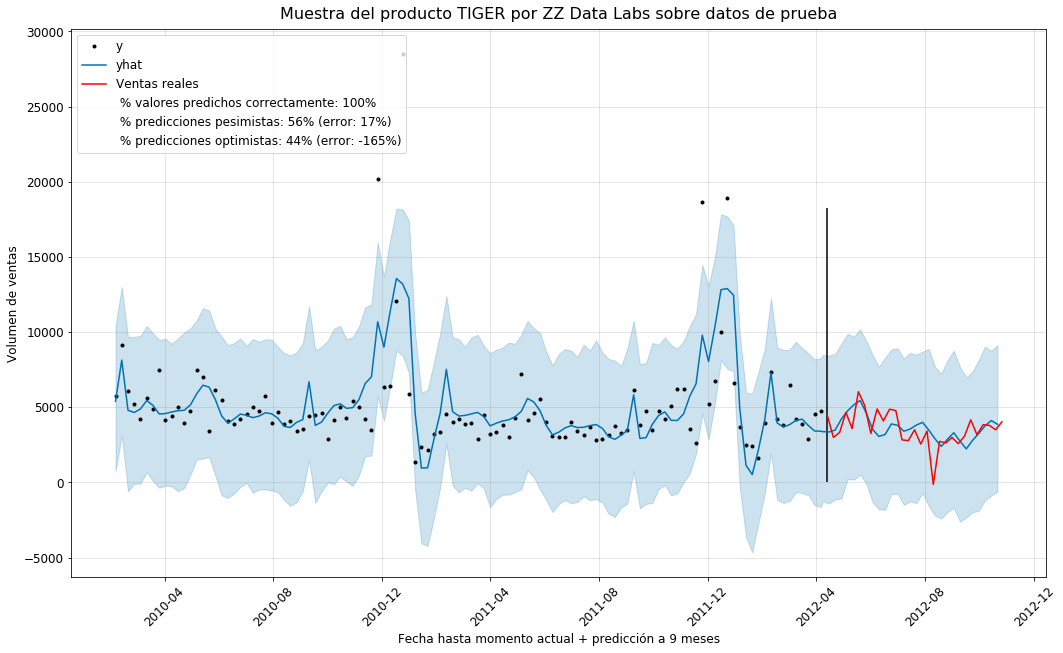

In [359]:
from matplotlib.patches import Rectangle
#plt.figure(num=None, figsize=(16, 9), dpi=200, facecolor='w', edgecolor='k')
predicciones_optimistas = int(np.sum((y_pred.values-y_test.values)/y_test.values > 0)/len(y_pred.values)*100)

fig1 = m.plot(forecast, xlabel="Fecha hasta momento actual + predicción a 9 meses", ylabel="Volumen de ventas")
fig1.set_size_inches(16,9)
fig2 = plt.plot(scaled_features_test.ds, y_test, 'r', label='Ventas reales')
ax = fig1.add_subplot(111)
plt.rcParams.update({'font.size': 12})
plt.xticks(rotation=45)
plt.title('Muestra del producto TIGER por ZZ Data Labs sobre datos de prueba', pad=10, fontdict={'fontsize': 16, 'fontweight': 'medium'})

plt.plot([], [], ' ', label=" % valores predichos correctamente: " +str(int(isBetweenUncertainty(y_test, y_pred_lower, y_pred_upper)))+"%")
plt.plot([], [], ' ', label=" % predicciones pesimistas: "+str(100-predicciones_optimistas) + "% (error: " + str(mean_pesimista) + "%)")
plt.plot([], [], ' ', label=" % predicciones optimistas: "+str(predicciones_optimistas) + "% (error: " + str(mean_optimista) + "%)")

plt.vlines(scaled_features_test.ds[0], 0, max(forecast.yhat_upper))

ax.legend(loc=2)
#plt.figsize(16,9)
#plt.tick_params(labelsize=12)
plt.grid(True)
plt.show()
#plt.gcf().subplots_adjust(bottom=0.15)

In [287]:
plt.savefig('store1_dpt9.png')

<Figure size 360x720 with 0 Axes>

# Todo aglutinado en una función

In [18]:
# TODO: que se pueda seleccionar tienda (actualmente solo funciona con la tienda 1)
def process_dept(dept, features_freedom=0.05, test_size=0.2):
    store_1_dpt_n = train[np.logical_and(train.Store==1, train.Dept==dept)]
    # Los divide en train-test
    X_train, X_test, y_train, y_test = train_test_split(store_1_dpt_n.drop(columns=['Weekly_Sales']),
                                                                       store_1_dpt_n.Weekly_Sales, 
                                                                       test_size=test_size, 
                                                                       shuffle=False)
    # Nos cepillamos los valores negativos (no pueden ser)
    y_train[y_train < 0] = np.mean(y_train)
    y_test[y_test < 0] = np.mean(y_test)
    # Cata las features
    features = pd.read_csv(os.path.join(path,'features.csv'), parse_dates=True)
    # Te cata las features pero solo de la tienda uno
    # TODO: que cate las features correspondientes en función de la tienda seleccionada
    features['Date'] = pd.to_datetime(features.Date)
    features = features[:X_train.shape[0]+X_test.shape[0]]
    features_train = features[:X_train.shape[0]]
    features_test = features[X_train.shape[0]:]
    # C mete con un valor esperado en Prophet los valores de salida
    X_train['y'] = y_train.values
    X_test['y'] = y_test.values
    # Te une las features con el x_train
    X_train2 = pd.merge(X_train, features_train).drop(columns=['Store','Dept','MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4','MarkDown5'])
    # Te pone 0 donde hay Nan
    # TODO: interpolar los valores
    X_train2.fillna(0, inplace=True)
    # Te normaliza las features independientemente mediante función gausiana
    scaled_features_train = X_train2.copy()
    col_names = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
    features_ = scaled_features_train[col_names]
    scaler = StandardScaler().fit(features_.values)
    features_ = scaler.transform(features_.values)
    scaled_features_train[col_names] = features_
    # Lo mismo de antes pa test
    X_test2 = pd.merge(X_test, features_test).drop(columns=['Store','Dept','MarkDown1', 'MarkDown2','MarkDown3', 'MarkDown4','MarkDown5'])
    X_test2.fillna(0, inplace=True)
    scaled_features_test = X_test2.copy()
    col_names = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
    features_ = scaled_features_test[col_names]
    scaler = StandardScaler().fit(features_.values)
    features_ = scaler.transform(features_.values)
    scaled_features_test[col_names] = features_
    # C renombra para que cuadre con lo esperado por Prophet
    scaled_features_train = scaled_features_train.rename(columns={"Date": "ds"})
    scaled_features_test = scaled_features_test.rename(columns={"Date": "ds"})
    # C mete con un valor esperado en Prophet los valores de salida
    ####scaled_features_train['y'] = y_train.values
    ####scaled_features_test['y'] = y_test.values
    # Los festivos los trata diferentes y hay que crear un dataframe exclusivo. C haC aquí.
    holidays = pd.DataFrame()
    holidays['ds'] = scaled_features_train['ds']
    holidays['holiday'] = scaled_features_train['IsHoliday']
    #scaled_features_train = scaled_features_train.drop(columns='IsHoliday')
    # Nos quedamos con los días que son festivos, quitamos los que non.
    holidays = holidays[(holidays != False).all(1)]
    # Le metemos una serie de variables adicionales que Prophet necesita.
    holidays['lower_window'] = np.zeros(len(holidays.values))
    holidays['upper_window'] = np.ones(len(holidays.values))
    holidays['holiday'] = "festivos en USA"
    # Instanciamos prophet con todos los parámetros que nos salga del Qlo
    #m = Prophet(mcmc_samples=100, holidays=holidays, holidays_prior_scale=0.1, changepoint_prior_scale=0.01, seasonality_mode='multiplicative', \
    #        weekly_seasonality=True, \
    #        daily_seasonality=False)
    #m = Prophet(weekly_seasonality=True, holidays=holidays, holidays_prior_scale=features_freedom, interval_width = 0.80)
    m = Prophet(
            growth='linear',
            changepoints=None,
            n_changepoints=25,
            changepoint_range=1,
            yearly_seasonality='auto',
            weekly_seasonality='auto',
            daily_seasonality='auto',
            holidays=None, #holidays
            seasonality_mode='additive',
            seasonality_prior_scale=1.0,
            changepoint_prior_scale=features_freedom,
            mcmc_samples=0,
            interval_width=0.8,
            uncertainty_samples=1000)
    # Le metemos a la instancia cada uno de los features, con el nombre que tenga la columna en el dataframe correspondiente
    #m.add_regressor('Temperature', prior_scale=features_freedom, mode='multiplicative')
    #m.add_regressor('Fuel_Price', prior_scale=features_freedom, mode='multiplicative')
    #m.add_regressor('CPI', prior_scale=features_freedom, mode='multiplicative')
    #m.add_regressor('Unemployment', prior_scale=features_freedom, mode='multiplicative')
    # Y fiteamos a fuego
    m.fit(scaled_features_train)#, control={'max_treedepth': 15})
    # Le metemos pa que haga predicción un dataframe con los datos presentes y los de test (en teoría futuros)
    all_data_features = pd.concat([scaled_features_train,scaled_features_test]).reset_index(drop=True)
    ####all_data_features.drop(columns=['ds','IsHoliday','y'])
    ####all_data_features.drop(columns=['ds','y'])
    
    # Y nos hace una predicción luxury
    future_train = m.make_future_dataframe(periods=len(scaled_features_test), freq="W")

    # Le damos explicitamente las features futuras (no las predice, logicamente)
    future_train = pd.concat([future_train, all_data_features[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']]], axis=1)
    # Y ya te hace la predicción completa con las features
    forecast = m.predict(future_train)
    # Que te pinte las componentes pa ver si ha hecho algo decente o ha sido chiripa
    #f = m.plot_components(forecast)
    # Pillamos las predicciones del dataframe que se genera (que tiene mazo de mierda) 
    y_pred = forecast.yhat[-X_test.shape[0]:]
    X_pred = forecast.yhat[:-X_test.shape[0]]
    
    y_pred[y_pred<0] = np.mean(y_pred)
    # Y ya que pinte lo que pasa en el futuro, con respecto del pasado, o lo que C a
    #plt.figure()
    #plt.grid()
    #plt.plot(scaled_features_train.ds, y_train)
    #plt.plot(scaled_features_test.ds, y_test,'k')
    #plt.plot(scaled_features_test.ds, y_pred, 'g')
    ###########################################################################################
    
    y_pred_lower = forecast.yhat_lower[-X_test.shape[0]:]
    y_pred_upper = forecast.yhat_upper[-X_test.shape[0]:]
    
    pred_optimista = y_pred.values > y_test.values
    pred_pesimista = np.logical_not(pred_optimista)
    try:
        mean_optimista = int(np.mean(np.abs(y_pred[pred_optimista].values-y_test[pred_optimista].values)/y_test[pred_optimista].values)*100)

    except:
        mean_optimista = "-"
    try:
        mean_pesimista = int(np.mean(np.abs(y_pred[pred_pesimista].values-y_test[pred_pesimista].values)/y_test[pred_pesimista].values)*100)
    except:
        mean_pesimista = "-"
    
    def isBetweenUncertainty(y_test, y_pred_lower, y_pred_upper):
        inside = 0
        for i in range(len(y_test)):
            if (y_test.values[i] < y_pred_upper.values[i]) and (y_test.values[i] > y_pred_lower.values[i]):
                inside += 1
        return (inside/len(y_test)*100)
    
    from sklearn.metrics import r2_score

    
    from matplotlib.patches import Rectangle
    predicciones_optimistas = int(np.sum((y_pred.values-y_test.values)/y_test.values > 0)/len(y_pred.values)*100)

    fig1 = m.plot(forecast, xlabel="Fecha hasta momento actual + predicción a 9 meses", ylabel="Volumen de ventas")
    fig1.set_size_inches(16,9)
    #fig2 = plt.plot(scaled_features_train.ds, y_train, 'r', label='Ventas reales')
    fig2 = plt.plot(scaled_features_test.ds, y_test, '.', color='k', label='_nolegend_')
    plt.vlines(scaled_features_test.ds[0], min(forecast.yhat_lower), max(forecast.yhat_upper))
    #fig2 = plt.plot(scaled_features_test.ds, y_pred, 'g', label='Ventas predichas')
    ax = fig1.add_subplot(111)
    plt.rcParams.update({'font.size': 12})
    plt.xticks(rotation=45)
    plt.title('Muestra del producto TIGER por ZZ Data Labs sobre datos de prueba (store 1, dept '+str(i)+')', pad=10, fontdict={'fontsize': 16, 'fontweight': 'medium'})

    plt.plot([], [], ' ', label=" % valores predichos correctamente: " +str(int(isBetweenUncertainty(y_test, y_pred_lower, y_pred_upper)))+"%")
    plt.plot([], [], ' ', label=" % predicciones optimistas: "+str(predicciones_optimistas) + "% (error: " + str(mean_optimista) + "%)")
    plt.plot([], [], ' ', label=" % predicciones pesimistas: "+str(100-predicciones_optimistas) + "% (error: " + str(mean_pesimista) + "%)")
    plt.plot([], [], ' ', label=" R^2: "+str(round(r2_score(y_pred, y_test), 2)))
    
    def percentage_error(y_pred, y_true):
        return np.mean(np.abs(y_pred-y_true)/y_true)*100
    
    plt.plot([], [], ' ', label=" % error global: "+str(round(percentage_error(y_pred.values, y_test.values),2))+"%")


    ax.legend(loc=2)
    #plt.figsize(16,9)
    #plt.tick_params(labelsize=12)
    plt.grid(True)
    plt.savefig('store1_dpt'+str(dept)+'_test'+str(test_size)+'%.png')
    plt.show()
    ###########################################################################################
    

    
    print('Error porcentual prophet: %0.02f' % percentage_error(y_pred.values, y_test.values) + '%')

    return percentage_error(y_pred, y_test)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning:


Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



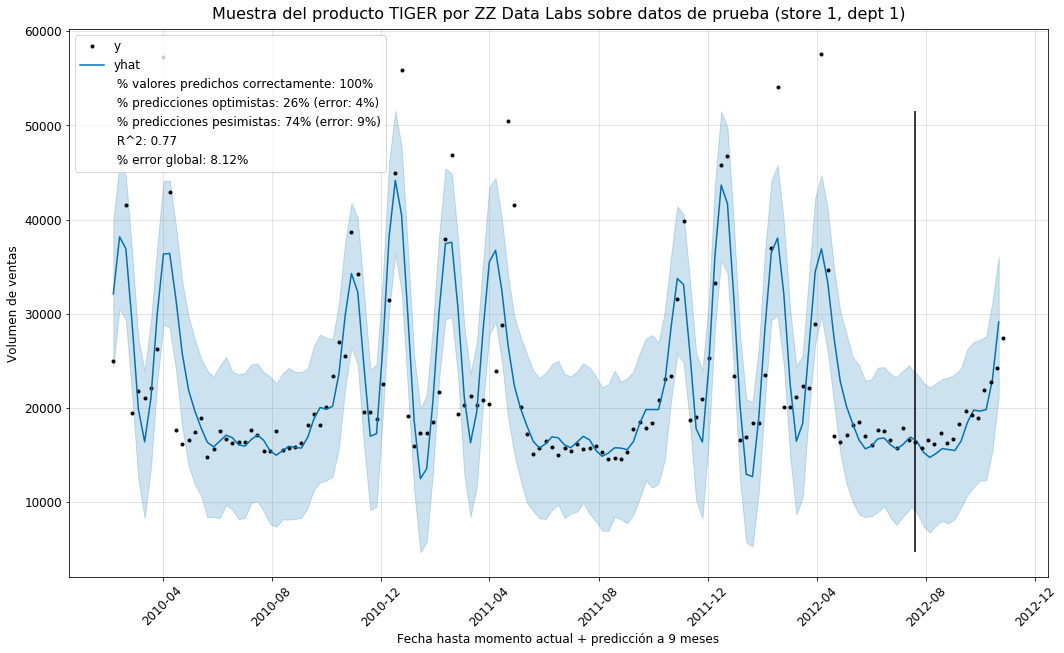

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Error porcentual prophet: 8.12%


/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning:


Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning:


Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



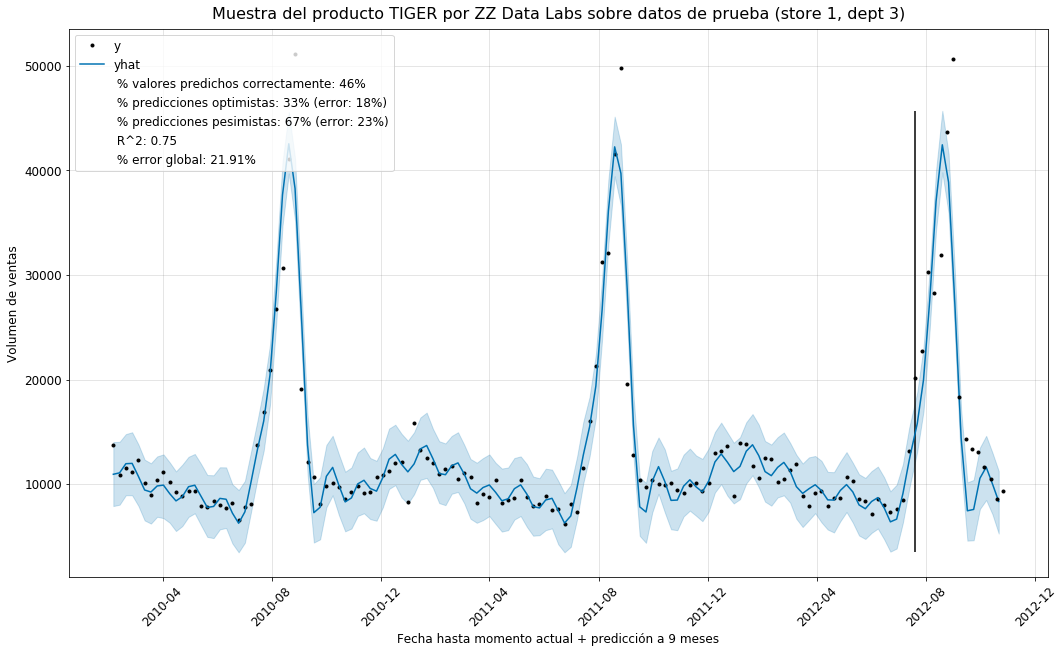

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Error porcentual prophet: 21.91%


/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning:


Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



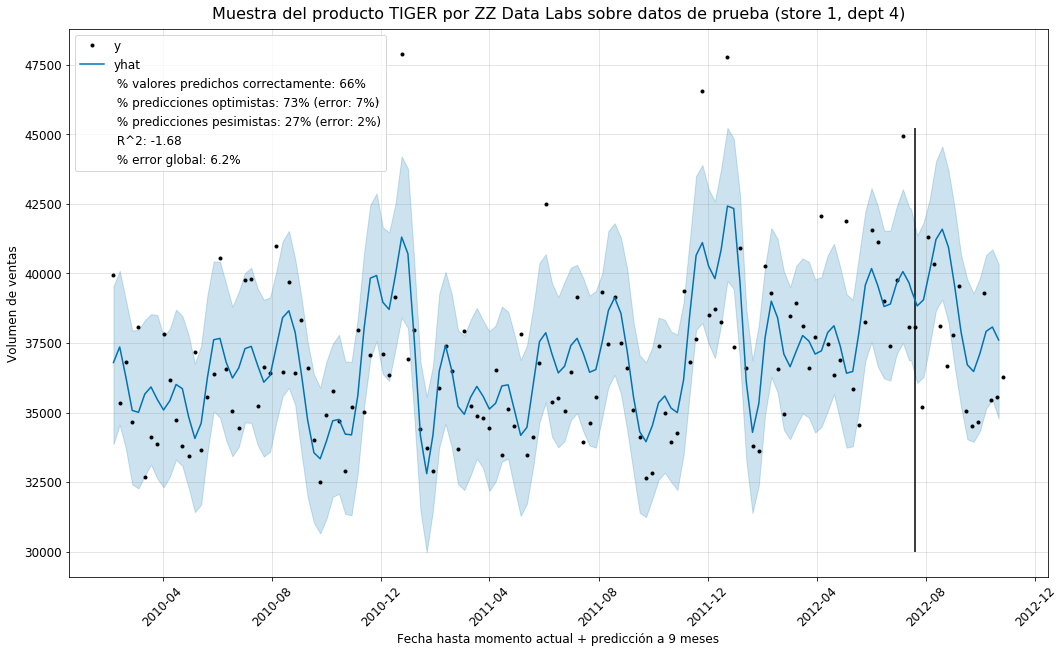

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Error porcentual prophet: 6.20%


/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning:


Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



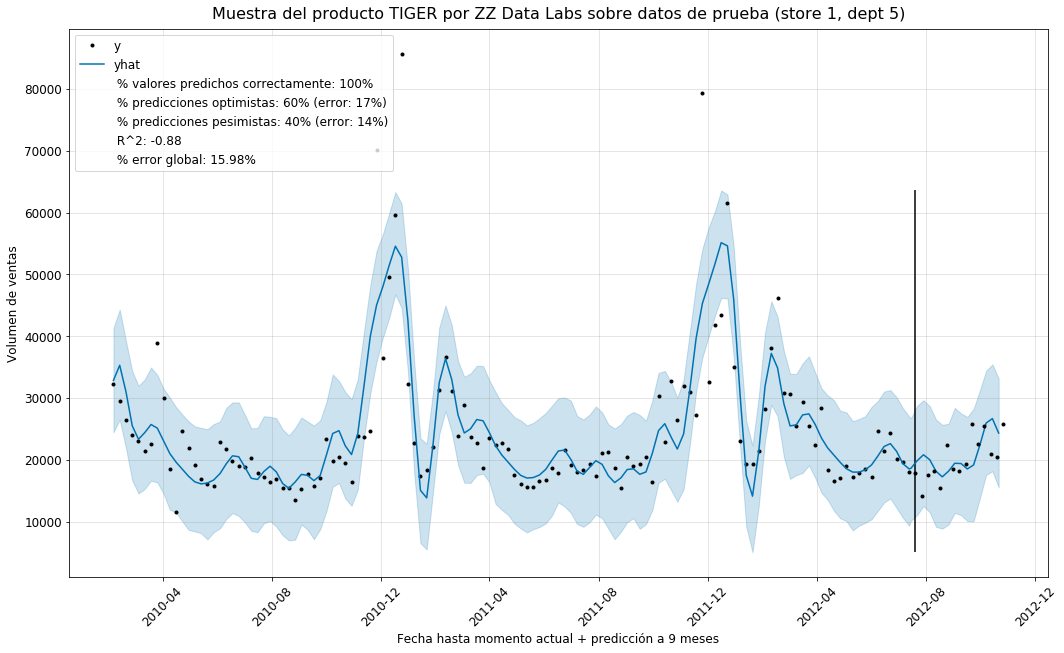

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Error porcentual prophet: 15.98%


/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning:


Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



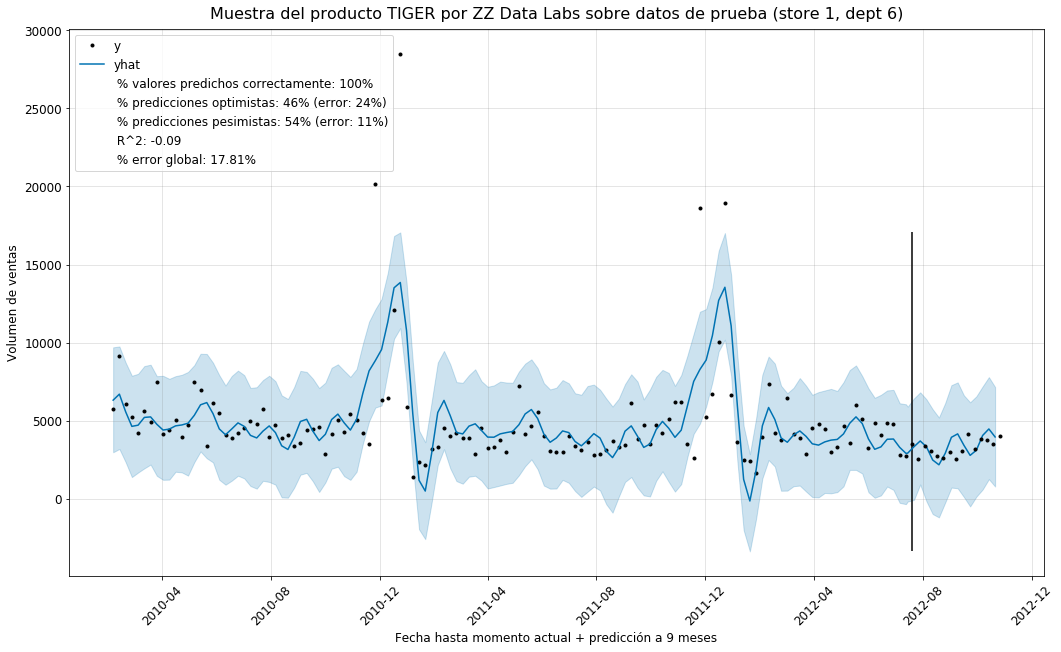

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Error porcentual prophet: 17.81%


/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning:


Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



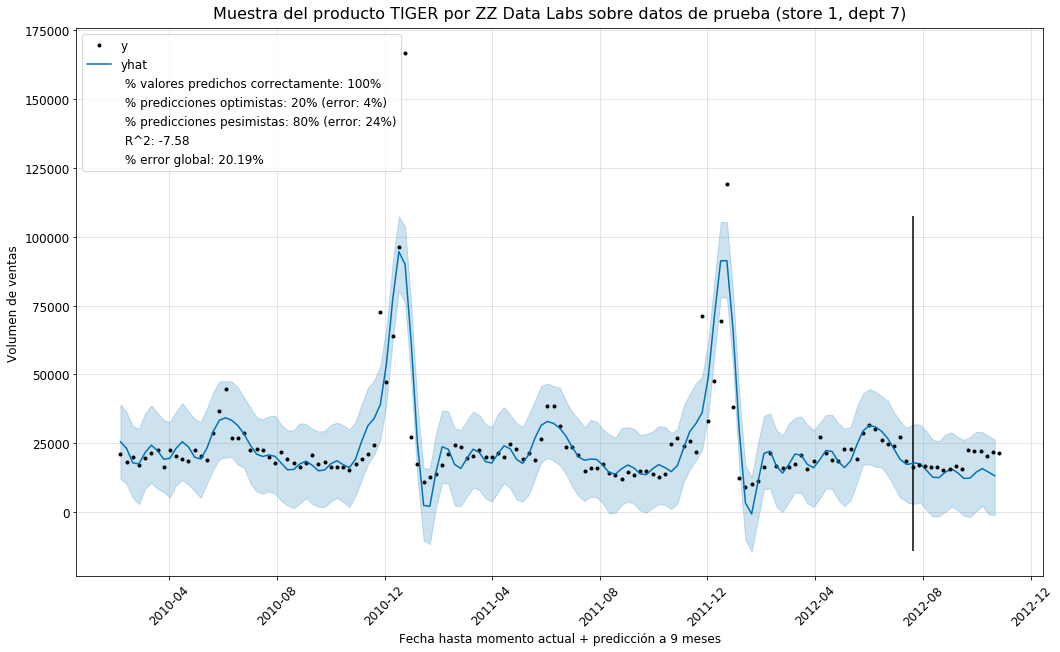

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Error porcentual prophet: 20.19%


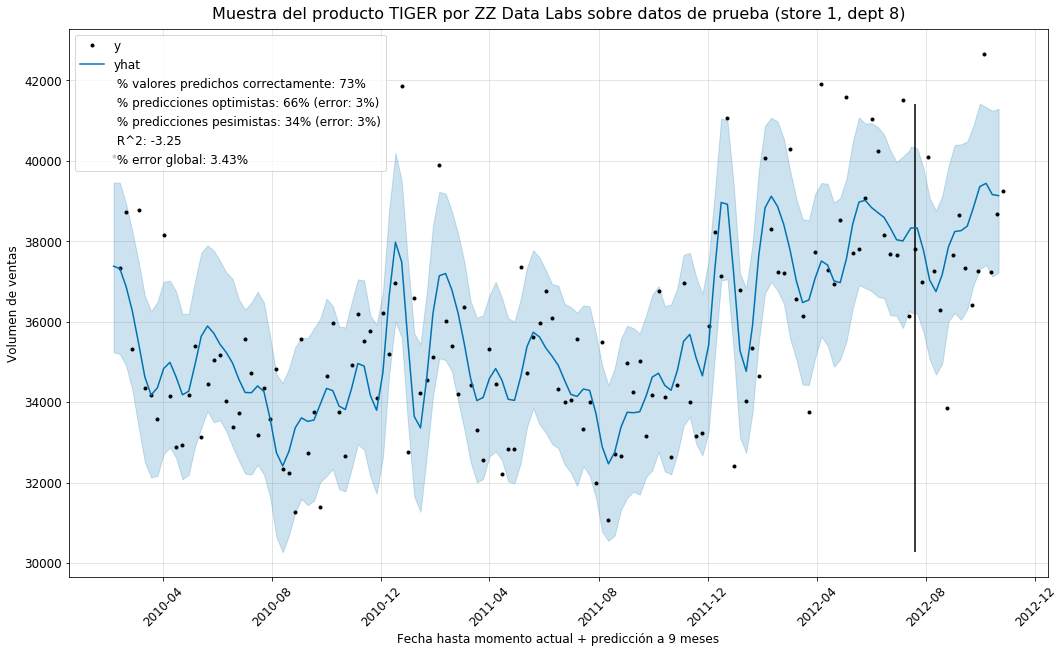

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Error porcentual prophet: 3.43%


/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning:


Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



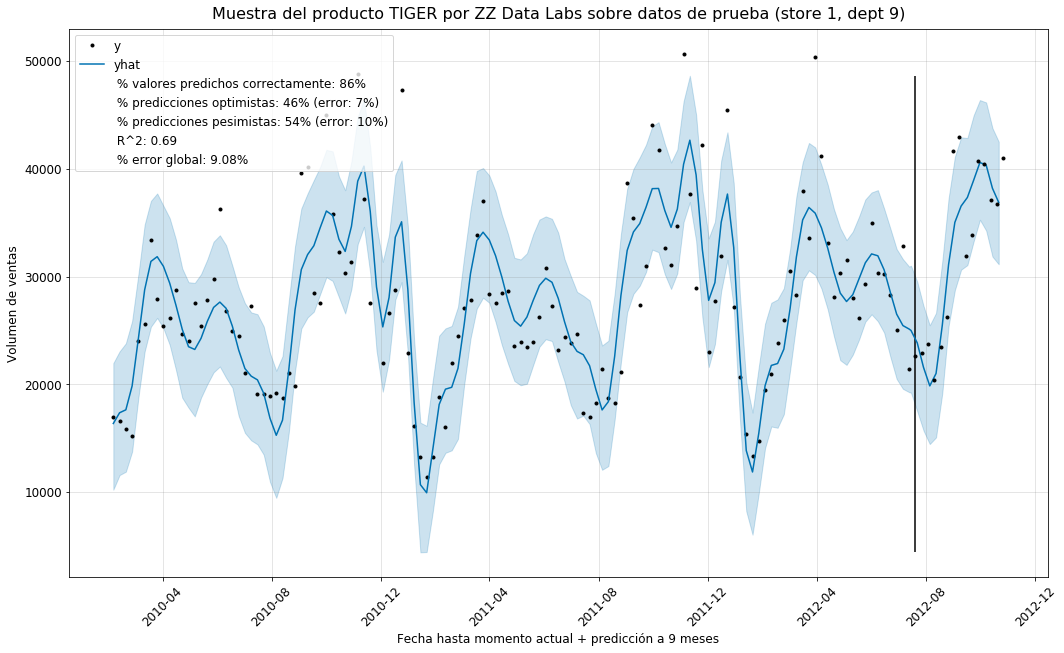

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Error porcentual prophet: 9.08%


/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning:


Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



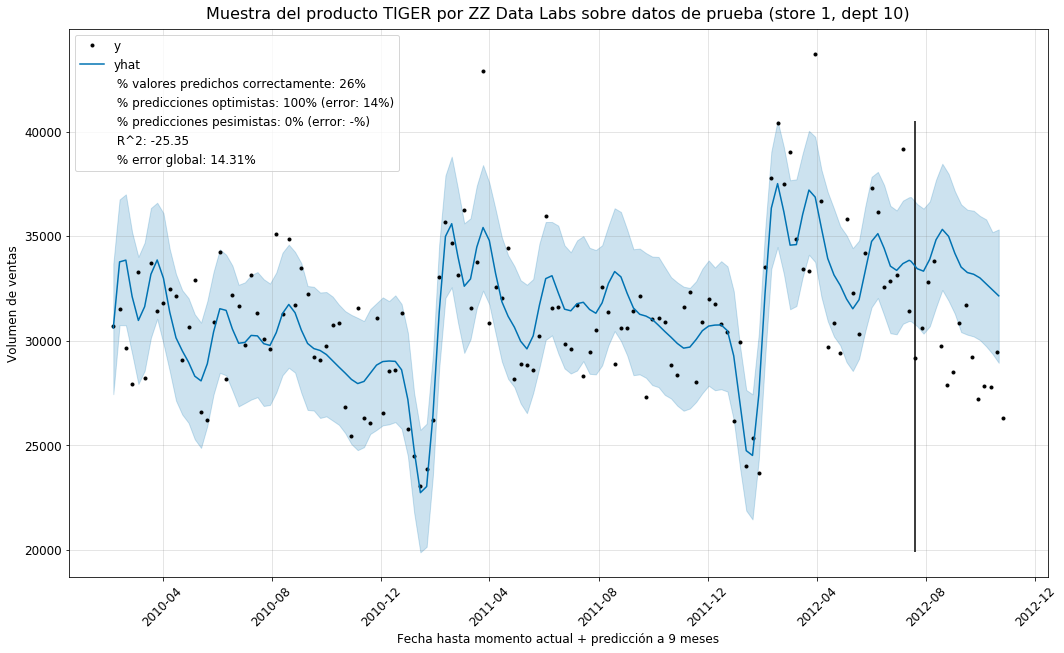

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Error porcentual prophet: 14.31%


/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning:


Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



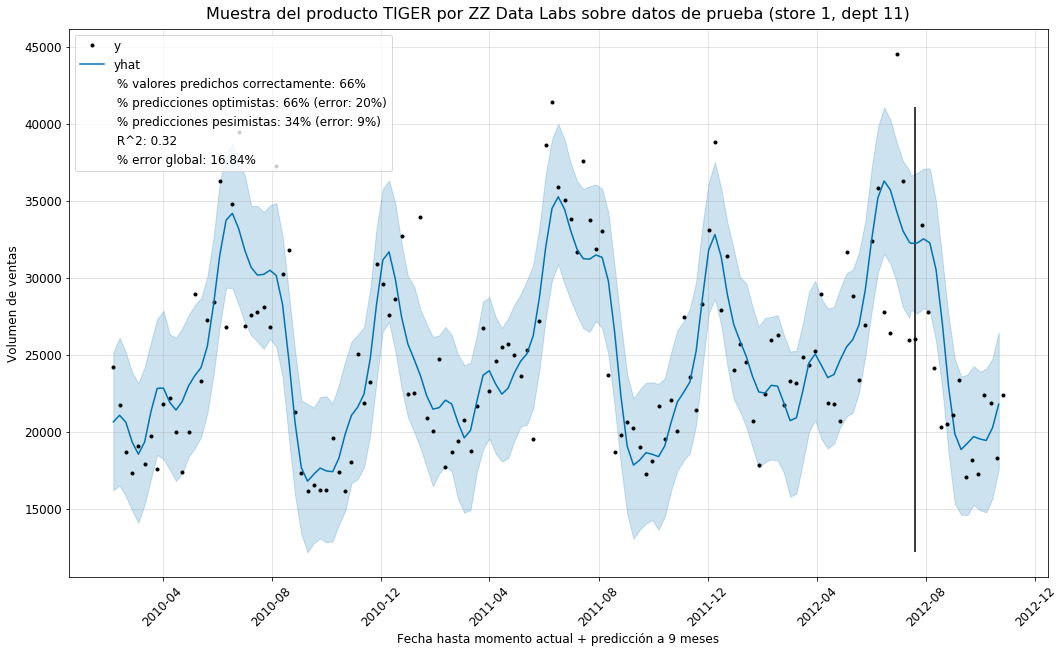

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Error porcentual prophet: 16.84%


/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning:


Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



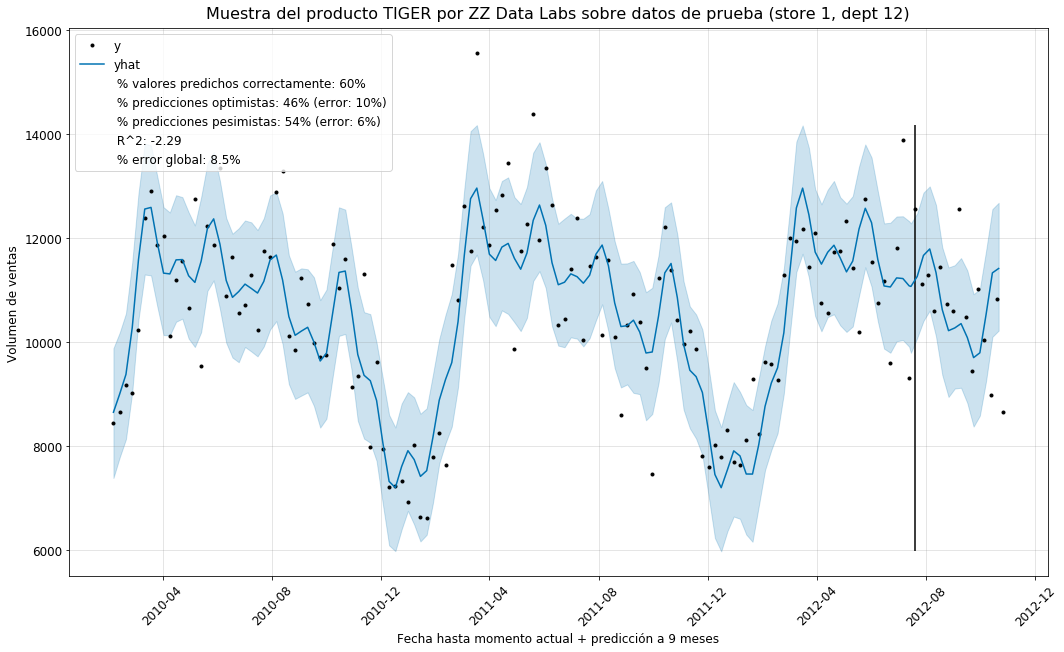

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Error porcentual prophet: 8.50%


/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning:


Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



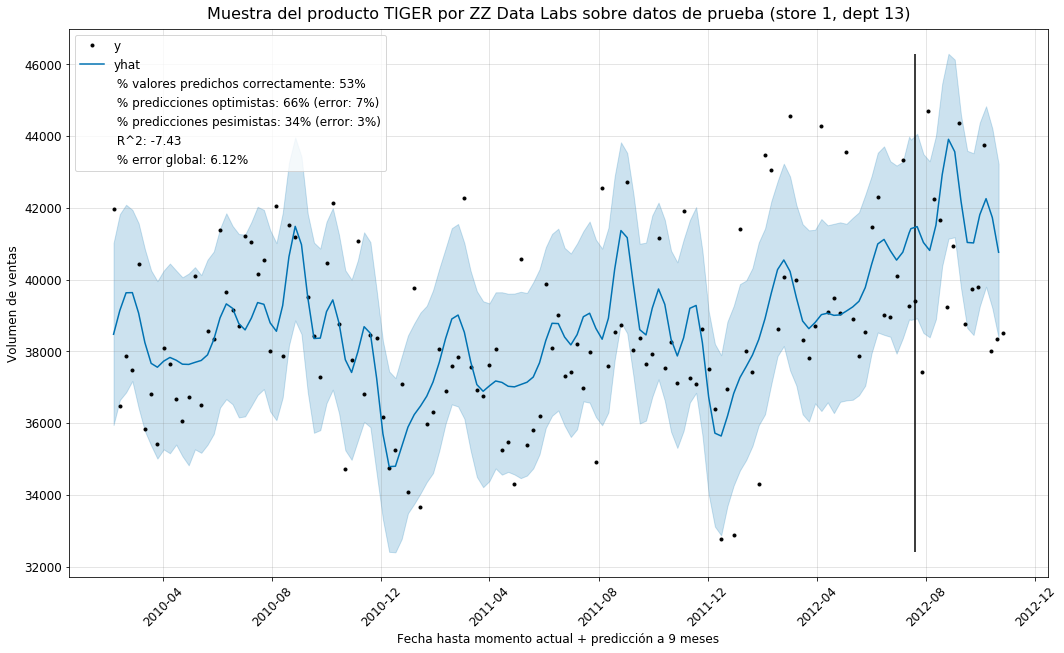

Error porcentual prophet: 6.12%
[8.12140739        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan]


In [19]:
N = 13
results = np.zeros(N)
for i in range(1,N+1):
    results[i-1] = process_dept(i, features_freedom=0.05, test_size=0.1)
    
print(results)

# add cross-validation r^^2

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning:


Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



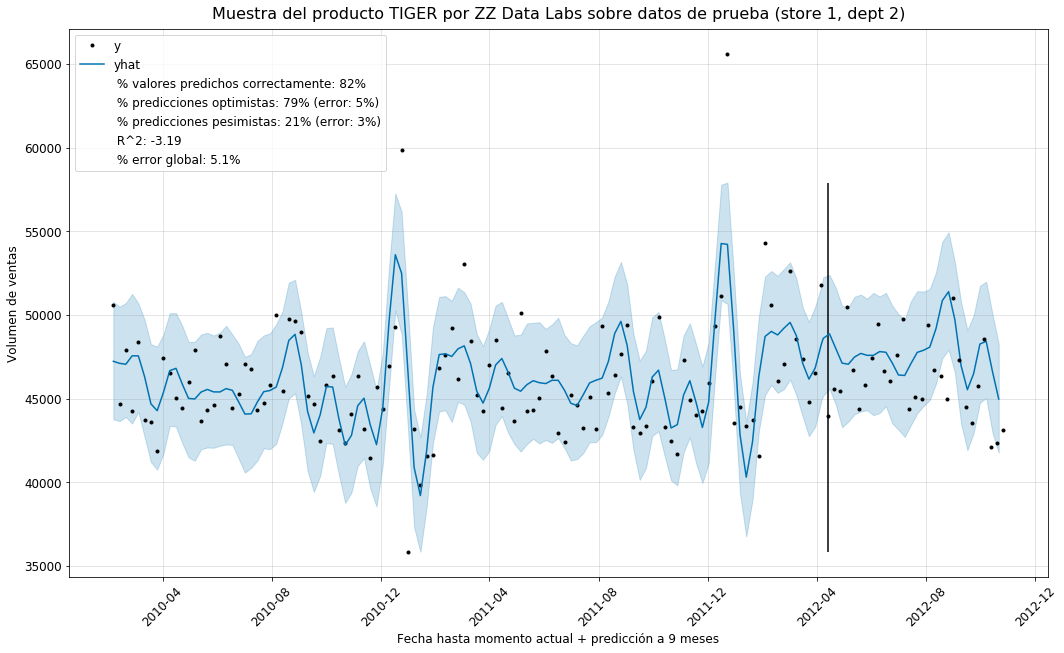

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Error porcentual prophet: 5.10%


/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning:


Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



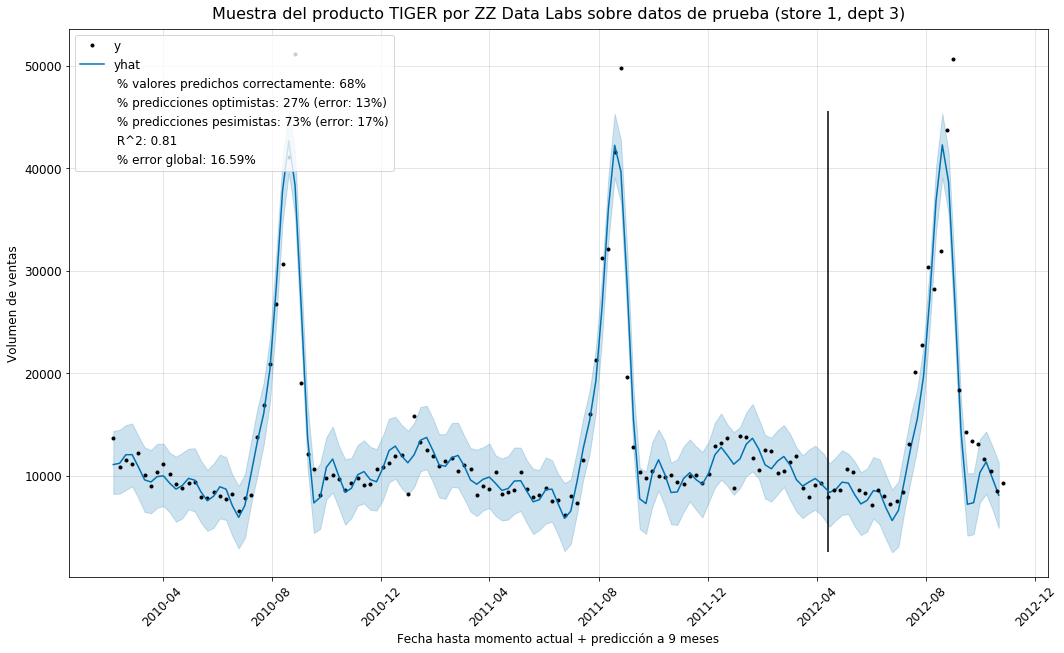

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Error porcentual prophet: 16.59%


/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning:


Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



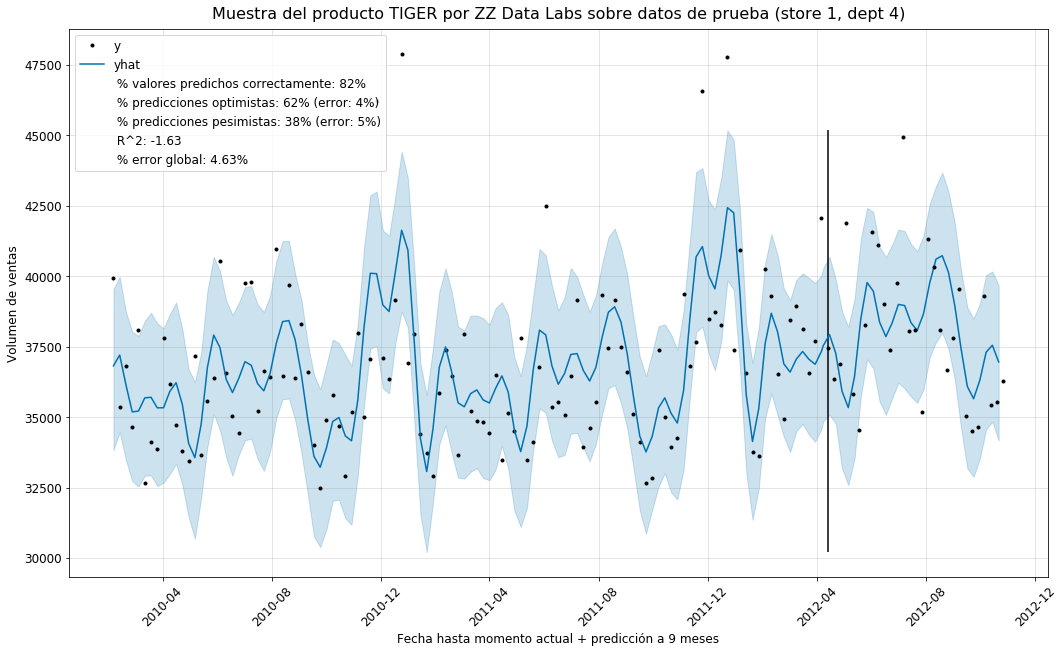

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Error porcentual prophet: 4.63%


/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning:


Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



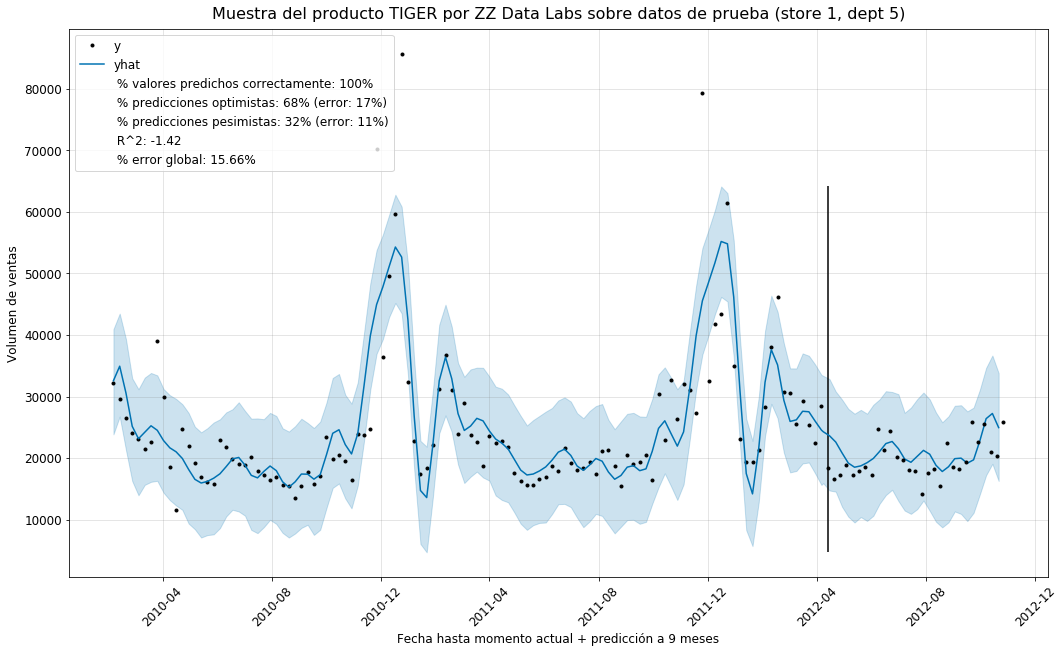

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Error porcentual prophet: 15.66%


/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning:


Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



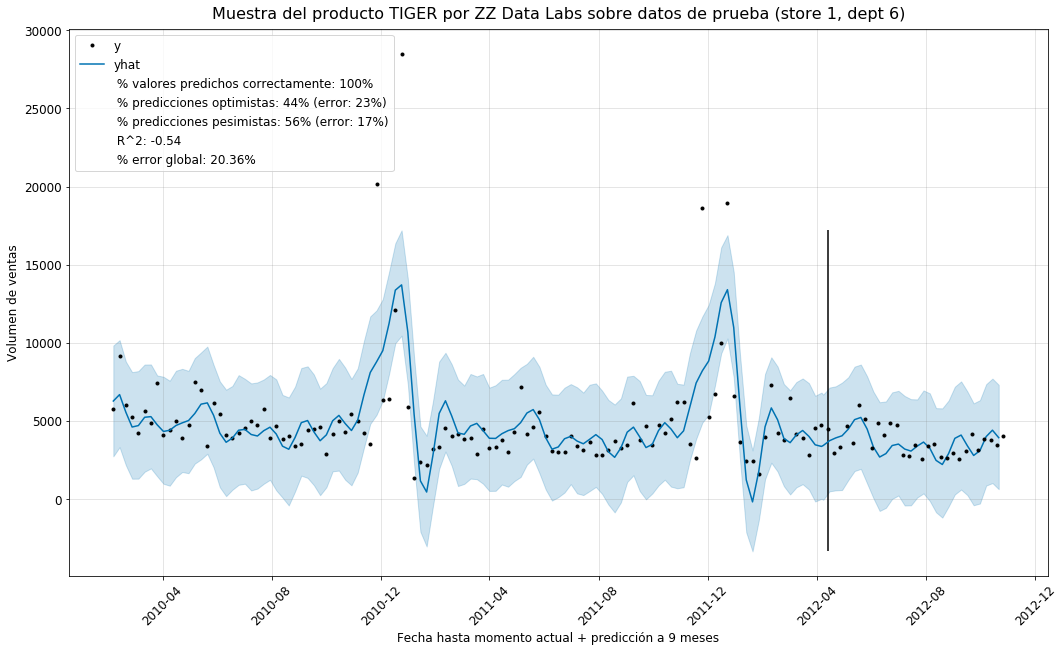

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Error porcentual prophet: 20.36%


/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning:


Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



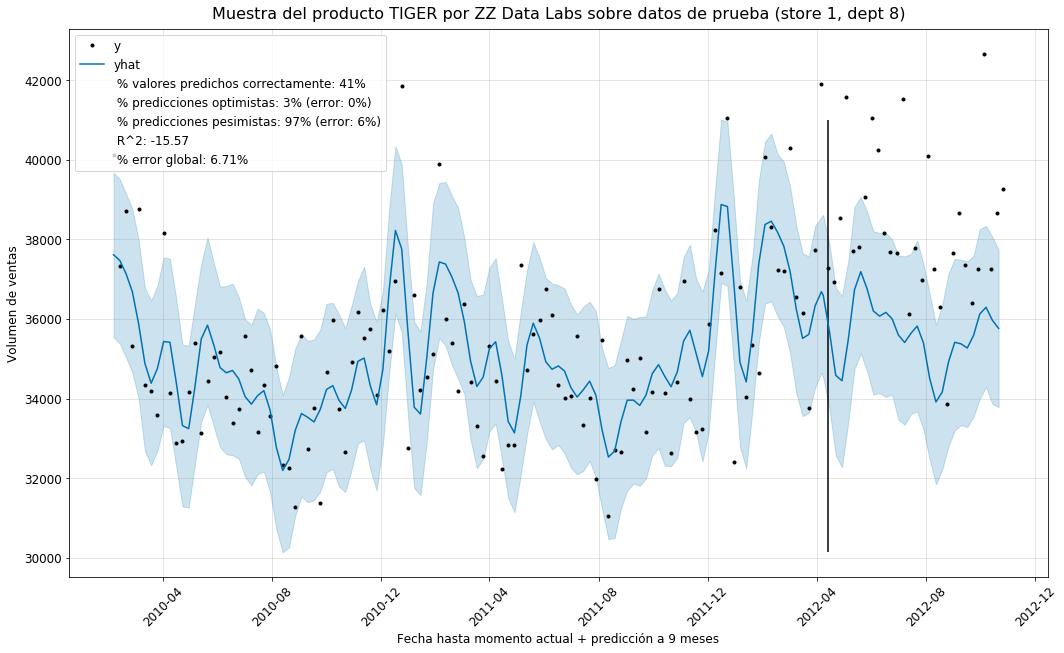

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Error porcentual prophet: 6.71%


/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning:


Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



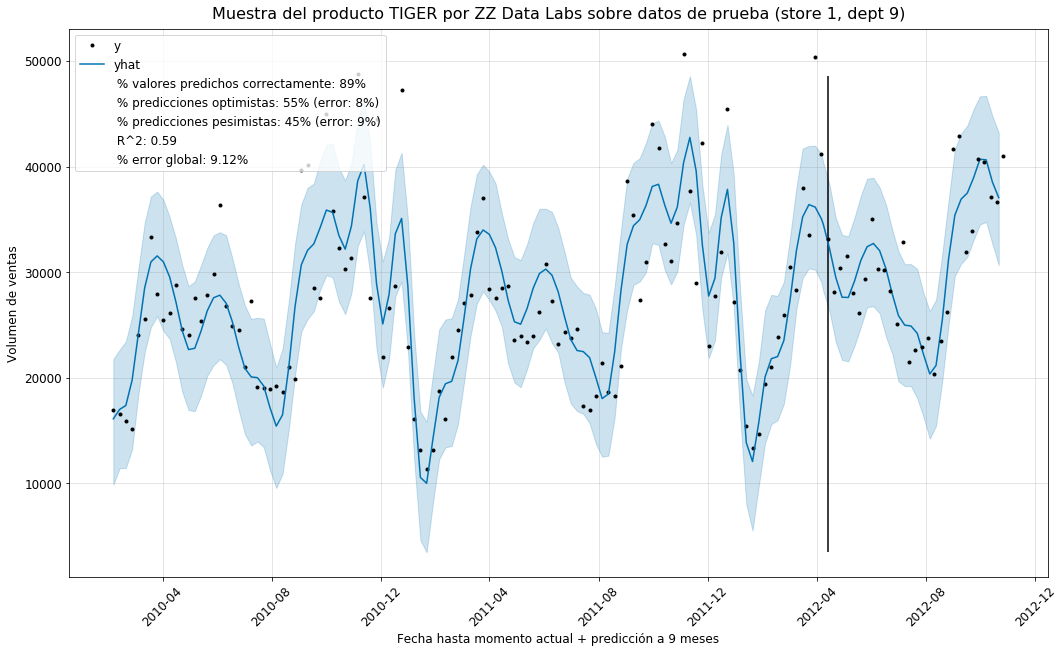

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Error porcentual prophet: 9.12%


/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning:


Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



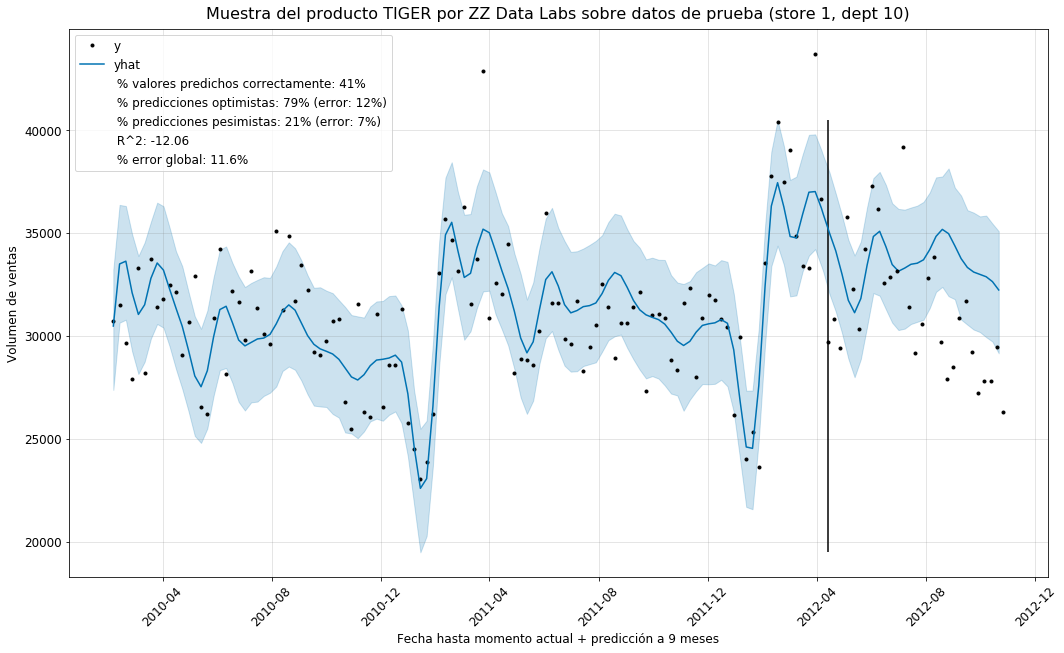

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Error porcentual prophet: 11.60%


/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning:


Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



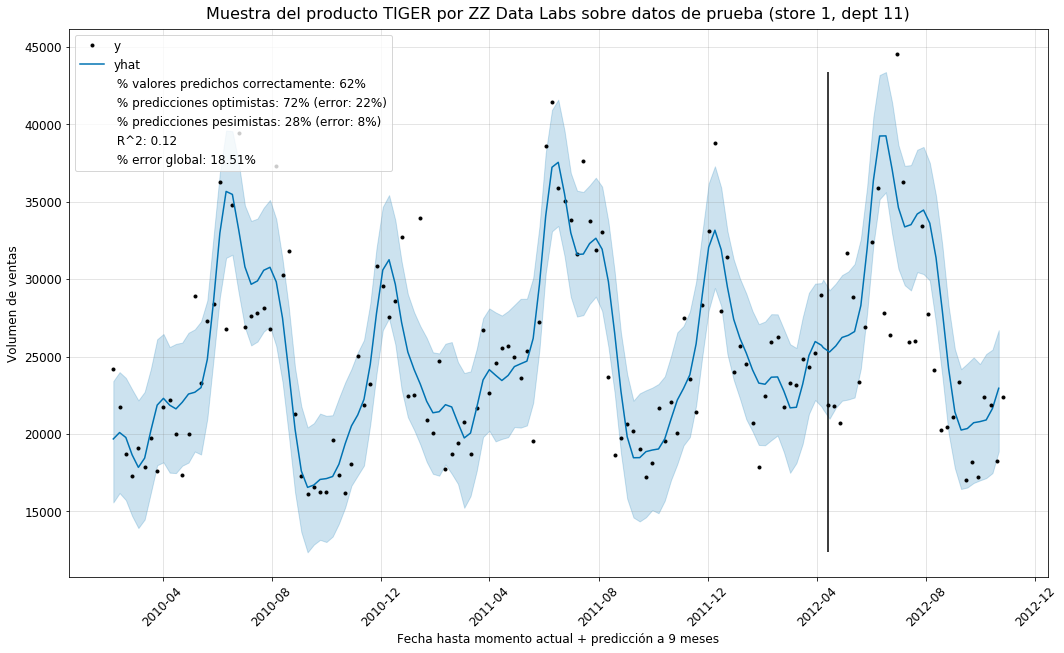

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Error porcentual prophet: 18.51%


/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning:


Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



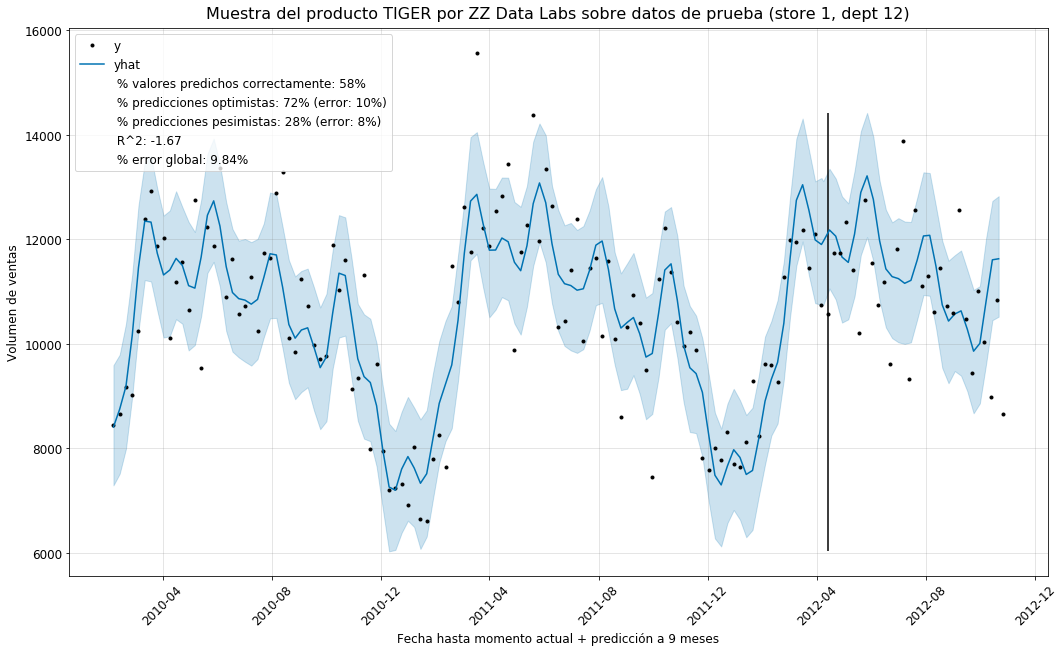

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Error porcentual prophet: 9.84%


/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning:


Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



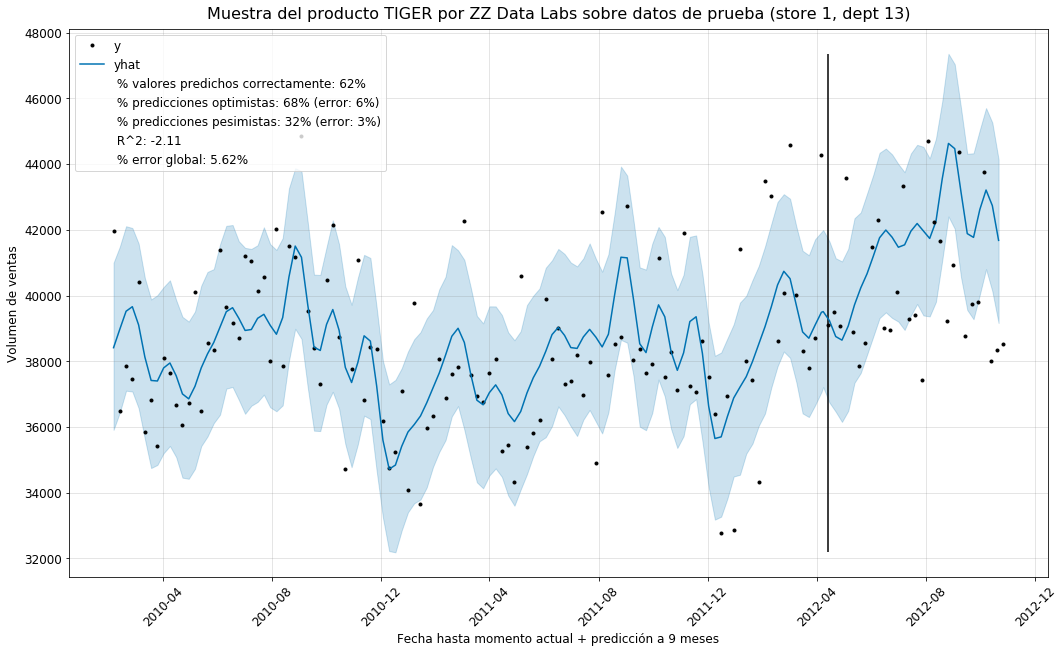

Error porcentual prophet: 5.62%
[13.81869065         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan]


In [ ]:
N = 13
results = np.zeros(N)
for i in range(1,N+1):
    results[i-1] = process_dept(i, features_freedom=0.05, test_size=0.2)
    
print(results)